### Login

In [ ]:
import pandas as pd
import sys
sys.path.append('/home/yangyuxi/QuantResearch/HKUquantDataSdk/')

from HKUquantDataSdk import HKUquantDataSdk
ds = HKUquantDataSdk(user='group1', password='PASSWORD')

In [2]:
mkt_open = '9:30:00'
mkt_close = '15:00:00'
lunch_begin = '11:30:00'
lunch_end = '13:00:00'
tickers = ['000063.SZ', '301236.SZ', '300339.SZ', '688041.SH', '300623.SZ', '688008.SH']

def get_data(start_date: str, end_date: str) -> pd.DataFrame:
    return ds.get_mins_history(
        tickers=tickers,
        fields=['Open', 'Close', 'Low', 'High', 'TurnoverRatio', 'ChangeRatio', 'AccChangeRatio', 'Volume', 'SellVolume', 'BuyVolume', 'Amount'],
        start_date=start_date.replace('-', ''),
        end_date=end_date.replace('-', ''),
        begin_time=mkt_open,
        end_time=mkt_close,
        price_mode='REAL',
        source='stock',
    )

### Preprocess

Make each row has the necessary data, including the gap, the parameters, the change ratio.

In [3]:
# Get raw data
date_range = ('2022-01-01', '2024-06-01')
raw_data: pd.DataFrame = get_data(*date_range)
raw_data

,ticker,TimeStamp,Open,Close,Low,High,TurnoverRatio,ChangeRatio,Volume,SellVolume,BuyVolume,Amount,AccChangeRatio
0,000063.SZ,2022-01-04 09:30:00,33.58,33.58,33.58,33.58,0.0023,0.2388,90100.0,32500.0,57600.0,3025558.0,0.238800
1,000063.SZ,2022-01-04 09:31:00,33.60,33.54,33.46,33.64,0.0215,-0.1191,836500.0,637800.0,238700.0,28083940.0,0.119416
2,000063.SZ,2022-01-04 09:32:00,33.49,33.43,33.40,33.51,0.0084,-0.3280,325800.0,161700.0,141100.0,10902558.0,-0.208976
3,000063.SZ,2022-01-04 09:33:00,33.45,33.37,33.35,33.45,0.0125,-0.1795,484900.0,364000.0,140300.0,16199437.0,-0.388101
4,000063.SZ,2022-01-04 09:34:00,33.40,33.43,33.36,33.43,0.0084,0.1798,327400.0,162700.0,134800.0,10925938.0,-0.208999
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795295,688041.SH,2024-05-31 14:56:00,69.87,69.86,69.85,69.92,0.0079,-0.0143,69255.0,37734.0,31521.0,4839690.0,0.503382
795296,688041.SH,2024-05-31 14:57:00,69.92,69.92,69.88,69.93,0.0067,0.0859,59102.0,32955.0,26147.0,4132270.0,0.589715
795297,688041.SH,2024-05-31 14:58:00,69.92,69.92,69.92,69.92,0.0001,0.0000,681.0,0.0,681.0,47620.0,0.589715
795298,688041.SH,2024-05-31 14:59:00,69.92,69.92,69.92,69.92,0.0000,0.0000,0.0,0.0,0.0,0.0,0.589715


In [4]:
def get_eod_data(start_date: str, end_date: str) -> pd.DataFrame:
    return ds.get_eod_history(
        tickers=tickers,
        fields=['Open', 'PreClose', 'Volume', 'Amount', 'ChangeRatio', 'UpAndDownStatus'],
        start_date=start_date.replace('-', ''),
        end_date=end_date.replace('-', ''),
        price_mode='AFTER',
        source='stock',
    )

In [5]:
# Get gaps
raw_eod_data = get_eod_data(*date_range)

In [6]:
raw_eod_data

{'Open': ticker       000063.SZ   300339.SZ   300623.SZ  301236.SZ  688008.SH  \
 TradingDay                                                             
 20220104    535.899593  144.640812  223.226074        NaN  84.750598   
 20220105    533.186582  147.360337  220.338923        NaN  85.486245   
 20220106    521.855768  139.644474  208.579064        NaN  81.928937   
 20220107    529.037270  141.225594  210.409940        NaN  77.696446   
 20220110    537.814660  132.118345  207.593207        NaN  76.567781   
 ...                ...         ...         ...        ...        ...   
 20240527    440.547191  136.988193  110.521831  90.300517  50.504654   
 20240528    445.296585  137.810376  116.218833  90.300517  53.253900   
 20240529    441.857369  135.849787  124.194635  88.454394  53.966667   
 20240530    438.254380  134.711381  124.764335  86.494312  53.539007   
 20240531    440.219647  135.913032  128.182536  87.360394  54.037944   
 
 ticker      688041.SH  
 TradingDay     

In [7]:
import datetime as dt

# Get gap per date
eod_data = pd.DataFrame(
    [
        *[
            (
                ticker,
                dt.date(int(open_price[0][:4]), int(open_price[0][4:6]), int(open_price[0][6:])),
                (float(open_price_ticker) - float(pre_close_ticker)) / float(pre_close_ticker),
                change_ratio_ticker,
                up_and_down_statud_ticker,
                volume_ticker,
                amount_ticker,
            )
            for (
                open_price, pre_close,
                change_ratio, up_and_down_status,
                volume, amount
            )
            in zip(
                raw_eod_data['Open'].iterrows(), raw_eod_data['PreClose'].iterrows(),
                raw_eod_data['ChangeRatio'].iterrows(), raw_eod_data['UpAndDownStatus'].iterrows(),
                raw_eod_data['Volume'].iterrows(), raw_eod_data['Amount'].iterrows(),
            )
            for (
                (ticker, open_price_ticker), pre_close_ticker,
                change_ratio_ticker, up_and_down_statud_ticker,
                volume_ticker, amount_ticker,
            )
            in zip(
                open_price[1].items(), pre_close[1],
                change_ratio[1], up_and_down_status[1],
                volume[1], amount[1]
            )
        ]
    ],
    columns=[
        'ticker', 'TradingDay', 'Gap',
        'ChangeRatioEod', 'UpAndDownStatus',
        'VolumeEod', 'AmountEod',
    ],
)
eod_data[:20]

,ticker,TradingDay,Gap,ChangeRatioEod,UpAndDownStatus,VolumeEod,AmountEod
0,000063.SZ,2022-01-04,0.002388,-0.2388,0.0,290034.38,968728.059
1,300339.SZ,2022-01-04,0.004392,1.4054,0.0,289555.14,667309.800
2,300623.SZ,2022-01-04,0.007629,-0.7629,0.0,79080.27,247467.745
3,301236.SZ,2022-01-04,NaN,NaN,NaN,NaN,NaN
4,688008.SH,2022-01-04,0.002742,0.7512,0.0,57897.73,487532.504
5,688041.SH,2022-01-04,NaN,NaN,NaN,NaN,NaN
6,000063.SZ,2022-01-05,-0.000299,-1.4063,0.0,393240.81,1301922.556
7,300339.SZ,2022-01-05,0.009095,-3.6379,0.0,383649.08,863940.547
8,300623.SZ,2022-01-05,0.002242,-4.1960,0.0,160465.58,483141.627
9,301236.SZ,2022-01-05,NaN,NaN,NaN,NaN,NaN


In [8]:
index = '399001.SZ'

In [9]:
def get_index_data(start_date: str, end_date: str) -> pd.DataFrame:
    return ds.get_eod_history(
        tickers=[index],
        fields=['Open', 'PreClose', 'Volume', 'Amount', 'ChangeRatio'],
        start_date=start_date.replace('-', ''),
        end_date=end_date.replace('-', ''),
        price_mode='AFTER',
        source='index',
    )

In [10]:
raw_index_eod_data = get_index_data(*date_range)
raw_index_eod_data

{'Open': StockIndexCode   399001.SZ
 TradingDay                
 20220104        14935.2277
 20220105        14752.0826
 20220106        14432.4586
 20220107        14449.5403
 20220110        14304.8596
 ...                    ...
 20240527         9444.2276
 20240528         9489.0824
 20240529         9387.6497
 20240530         9395.7880
 20240531         9388.2686
 
 [582 rows x 1 columns],
 'PreClose': StockIndexCode   399001.SZ
 TradingDay                
 20220104        14857.3453
 20220105        14791.3136
 20220106        14525.7588
 20220107        14429.5075
 20220110        14343.6547
 ...                    ...
 20240527         9424.5771
 20240528         9507.7451
 20240529         9391.0520
 20240530         9414.9792
 20240531         9384.7234
 
 [582 rows x 1 columns],
 'Volume': StockIndexCode    399001.SZ
 TradingDay                 
 20220104        570546865.0
 20220105        583832783.0
 20220106        513516006.0
 20220107        561849847.0
 20220110     

In [11]:
import datetime as dt

# Get index gap per date
index_eod_data = pd.DataFrame(
    [
        (
            dt.date(int(open_price[0][:4]), int(open_price[0][4:6]), int(open_price[0][6:])),
            (float(open_price[1].iloc[0]) - float(pre_close[1].iloc[0])) / float(pre_close[1].iloc[0]),
            change_ratio[1].iloc[0],
        )
        for open_price, pre_close, change_ratio
        in zip(raw_index_eod_data['Open'].iterrows(), raw_index_eod_data['PreClose'].iterrows(), raw_index_eod_data['ChangeRatio'].iterrows())
    ],
    columns=['TradingDay', 'IndexGap', 'IndexChangeRatioEod'],
)
index_eod_data[:10]

,TradingDay,IndexGap,IndexChangeRatioEod
0,2022-01-04,0.005242,-0.4444
1,2022-01-05,-0.002652,-1.7953
2,2022-01-06,-0.006423,-0.6626
3,2022-01-07,0.001388,-0.5950
4,2022-01-10,-0.002705,0.4414
5,2022-01-11,-0.000330,-1.2745
6,2022-01-12,0.006551,1.3910
7,2022-01-13,0.001372,-1.9614
8,2022-01-14,-0.005918,0.0865
9,2022-01-17,0.000878,1.5052


In [37]:
import datetime as dt
from typing import Generator, Iterable, Optional

def map_name(features: Iterable[str], suffix: str) -> Generator[str, None, None]:
    return (f'{col}{suffix}' for col in features)

# Merge with the gaps
data = raw_data.merge(eod_data, left_on=(raw_data['TimeStamp'].dt.date, 'ticker'), right_on=('TradingDay', 'ticker'))

# Merge with the index gaps
data = data.merge(index_eod_data, left_on=raw_data['TimeStamp'].dt.date, right_on='TradingDay')

data['Time'] = data['TimeStamp'].dt.time

# Compute buy volume ratio
data['BuyVolumeRatio'] = data['BuyVolume'] / data['Volume']

# Compute time since market open in minutes
data['MarketOpenMins'] = pd.to_timedelta(data['Time'].astype(str)).dt.total_seconds().div(60).astype(int) - 570

# Compute time since market open in fraction
data['MarketOpen'] = data['MarketOpenMins'] / 30.0

# (Kind of) normalize the amount traded
data['AmountNormalized'] = data['Amount'] / 100_000_000

# Adjusted gap
data['GapAdjusted'] = data['Gap'] / data['IndexGap']

# Adjusted change ratio eod
data['ChangeRatioEodAdjusted'] = data['ChangeRatioEod'] / data['IndexChangeRatioEod']

# Max volume and amount
data['VolumeEodMax'] = data.groupby('ticker')['VolumeEod'].transform('max')
data['AmountEodMax'] = data.groupby('ticker')['AmountEod'].transform('max')

# Volume and amount ratio
data['VolumeEodRatio'] = data['VolumeEod'] / data['VolumeEodMax']
data['AmountEodRatio'] = data['AmountEod'] / data['AmountEodMax']

# Volatility and mean of previous day
def shift_trading_day(data: pd.DataFrame, columns: list[str]) -> pd.DataFrame:
    new_data = data[['ticker', 'TradingDay', *columns]]
    data = data.drop(columns, axis=1)
    new_data = new_data.drop_duplicates()
    new_data['TradingDay'] = pd.to_datetime(new_data['TradingDay']).dt.date + dt.timedelta(days=1)
    return data.merge(new_data, on=('ticker', 'TradingDay'))

data['ChangeRatioStdPre'] = data.groupby(['ticker', 'TradingDay'])['ChangeRatio'].transform('std')
data['ChangeRatioMeanPre'] = data.groupby(['ticker', 'TradingDay'])['ChangeRatio'].transform('mean')

# Previous day change ratio eod
data['ChangeRatioEodPre'] = data['ChangeRatioEod']
data['IndexChangeRatioEodPre'] = data['IndexChangeRatioEod']
data['ChangeRatioEodAdjustedPre'] = data['ChangeRatioEodAdjusted']
data['UpAndDownStatusPre'] = data['UpAndDownStatus']
data['VolumeEodPre'] = data['VolumeEod']
data['AmountEodPre'] = data['AmountEod']
data['VolumeEodRatioPre'] = data['VolumeEodRatio']
data['AmountEodRatioPre'] = data['AmountEodRatio']

data = shift_trading_day(data, [
    'ChangeRatioStdPre', 'ChangeRatioMeanPre', 'ChangeRatioEodPre',
    'IndexChangeRatioEodPre', 'ChangeRatioEodAdjustedPre', 'UpAndDownStatusPre',
    'VolumeEodPre', 'AmountEodPre', 'VolumeEodRatioPre', 'AmountEodRatioPre',
])

# Morning volatility and mean
data_morning = data[(data['Time'] < dt.time(10, 0))]
data['ChangeRatioStdMorning'] = data_morning.groupby(['ticker', 'TradingDay'])['ChangeRatio'].transform('std')
data['ChangeRatioMeanMorning'] = data_morning.groupby(['ticker', 'TradingDay'])['ChangeRatio'].transform('mean')

features = ['ChangeRatio', 'Open', 'Close', 'High', 'Low', 'TurnoverRatio', 'AccChangeRatio', 'BuyVolumeRatio', 'AmountNormalized', 'MarketOpen']

# Also get previous min data
# data[[*map_name(features, 'Pre')]] = data[features].shift(1)

# Also get next min data
# data[[*map_name(features, 'Next')]] = data[features].shift(-1)

# Features
day_features = [
    'TradingDay', 'ChangeRatioStdPre', 'ChangeRatioMeanPre', 'Gap', 'IndexGap', 'GapAdjusted', 'ChangeRatioStdMorning', 'ChangeRatioMeanMorning',
    'ChangeRatioEod', 'IndexChangeRatioEod', 'ChangeRatioEodAdjusted', 'ChangeRatioEodPre', 'IndexChangeRatioEodPre', 'ChangeRatioEodAdjustedPre',
    'UpAndDownStatus', 'UpAndDownStatusPre', 'VolumeEod', 'VolumeEodPre', 'AmountEod', 'AmountEodPre', 'VolumeEodRatioPre', 'AmountEodRatioPre',
]
all_features = ['ticker', 'Time', *features, *day_features]
data = data[all_features]
day_data = data[['ticker', *day_features]].drop_duplicates()

data

,ticker,Time,ChangeRatio,Open,Close,High,Low,TurnoverRatio,AccChangeRatio,BuyVolumeRatio,...,IndexChangeRatioEodPre,ChangeRatioEodAdjustedPre,UpAndDownStatus,UpAndDownStatusPre,VolumeEod,VolumeEodPre,AmountEod,AmountEodPre,VolumeEodRatioPre,AmountEodRatioPre
0,000063.SZ,09:30:00,-0.0299,33.41,33.41,33.41,33.41,0.0024,-0.029900,0.212418,...,-0.4444,0.537354,0.0,0.0,393240.81,290034.38,1301922.556,968728.059,0.080968,0.094829
1,000063.SZ,09:31:00,0.3592,33.40,33.53,33.58,33.36,0.0126,0.329193,0.625759,...,-0.4444,0.537354,0.0,0.0,393240.81,290034.38,1301922.556,968728.059,0.080968,0.094829
2,000063.SZ,09:32:00,0.3579,33.53,33.65,33.69,33.52,0.0161,0.688271,0.722718,...,-0.4444,0.537354,0.0,0.0,393240.81,290034.38,1301922.556,968728.059,0.080968,0.094829
3,000063.SZ,09:33:00,-0.2972,33.64,33.55,33.65,33.52,0.0082,0.389025,0.592552,...,-0.4444,0.537354,0.0,0.0,393240.81,290034.38,1301922.556,968728.059,0.080968,0.094829
4,000063.SZ,09:34:00,0.0894,33.58,33.58,33.59,33.52,0.0085,0.478773,0.645436,...,-0.4444,0.537354,0.0,0.0,393240.81,290034.38,1301922.556,968728.059,0.080968,0.094829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628282,688041.SH,14:56:00,-0.0143,69.87,69.86,69.92,69.85,0.0079,0.503382,0.455144,...,-0.3214,0.134101,0.0,0.0,123476.12,109962.17,870882.762,765472.088,0.092302,0.097328
628283,688041.SH,14:57:00,0.0859,69.92,69.92,69.93,69.88,0.0067,0.589715,0.442405,...,-0.3214,0.134101,0.0,0.0,123476.12,109962.17,870882.762,765472.088,0.092302,0.097328
628284,688041.SH,14:58:00,0.0000,69.92,69.92,69.92,69.92,0.0001,0.589715,1.000000,...,-0.3214,0.134101,0.0,0.0,123476.12,109962.17,870882.762,765472.088,0.092302,0.097328
628285,688041.SH,14:59:00,0.0000,69.92,69.92,69.92,69.92,0.0000,0.589715,NaN,...,-0.3214,0.134101,0.0,0.0,123476.12,109962.17,870882.762,765472.088,0.092302,0.097328


In [13]:
day_data.groupby('ticker').first()

,TradingDay,ChangeRatioStdPre,ChangeRatioMeanPre,Gap,IndexGap,GapAdjusted,ChangeRatioEod,IndexChangeRatioEod,ChangeRatioEodAdjusted,ChangeRatioEodPre,IndexChangeRatioEodPre,ChangeRatioEodAdjustedPre,UpAndDownStatus,UpAndDownStatusPre,VolumeEod,VolumeEodPre,AmountEod,AmountEodPre,VolumeEodRatioPre,AmountEodRatioPre
ticker,,,,,,,,,,,,,,,,,,,,
000063.SZ,2022-01-05,0.086107,-0.000956,-0.000299,-0.002652,0.112816,-1.4063,-1.7953,0.783323,-0.2388,-0.4444,0.537354,0.0,0.0,393240.81,290034.38,1301922.556,968728.059,0.080968,0.094829
300339.SZ,2022-01-05,0.126065,0.005870,0.009095,-0.002652,-3.429041,-3.6379,-1.7953,2.026347,1.4054,-0.4444,-3.162466,0.0,0.0,383649.08,289555.14,863940.547,667309.800,0.123624,0.105931
300623.SZ,2022-01-05,0.102354,-0.003123,0.002242,-0.002652,-0.845362,-4.1960,-1.7953,2.337214,-0.7629,-0.4444,1.716697,0.0,0.0,160465.58,79080.27,483141.627,247467.745,0.172386,0.254263
301236.SZ,2022-03-16,1.802329,-0.059693,0.039604,0.019768,2.003418,16.3201,4.0194,4.060332,-16.8496,-4.3635,3.861487,-2.0,-2.0,257206.76,250050.46,1706648.590,1560344.116,0.155817,0.205973
688008.SH,2022-01-05,0.187431,0.003280,0.003905,-0.002652,-1.472430,-3.7870,-1.7953,2.109397,0.7512,-0.4444,-1.690369,0.0,0.0,78569.60,57897.73,636517.364,487532.504,0.106115,0.133469
688041.SH,2022-08-16,0.523048,-0.021905,-0.014432,0.000837,-17.244470,6.8110,0.0794,85.780856,-5.4576,0.3288,-16.598540,-2.0,-2.0,452262.22,594756.30,2650930.792,3509521.338,0.499235,0.446227


### Regression

In [14]:
import matplotlib.pyplot as plt 
import numpy as np    

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = x_vals * slope + intercept
    plt.plot(x_vals, y_vals, color='black')

In [15]:
from scipy import stats


def print_stat(model, X, y):
    lm = model
    lm.fit(X,y)
    params = np.append(lm.intercept_,lm.coef_)
    predictions = lm.predict(X)

    # newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
    # MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

    # Note if you don't want to use a DataFrame replace the two lines above with
    newX = np.append(np.ones((len(X),1)), X, axis=1)
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]
    print(myDF3)

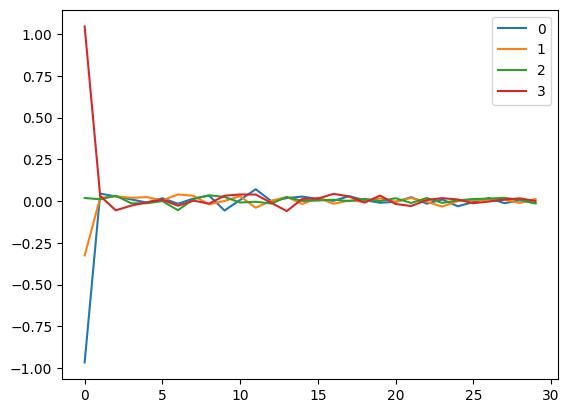

In [18]:
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pandas as pd
pd.options.mode.chained_assignment = None

d = data[(data['Time'] < dt.time(10)) & (data['ticker'] == '000063.SZ')]
gap_quantiles = d['Gap'].quantile([0.0, 0.25, 0.50, 0.75, 1.0]).to_numpy()

for i, (bottom, top) in enumerate(zip(gap_quantiles, gap_quantiles[1:])):
    dq = d[(d['Gap'] >= bottom) & (d['Gap'] < top)]
    dq['ChangeRatioMean'] = dq.groupby('MarketOpen')['ChangeRatio'].transform('mean')
    dq = dq[['ChangeRatioMean', 'MarketOpen']].drop_duplicates()['ChangeRatioMean'].reset_index()
    plt.plot(
        dq['ChangeRatioMean'],
        label=i,
    )

plt.legend()
plt.show()

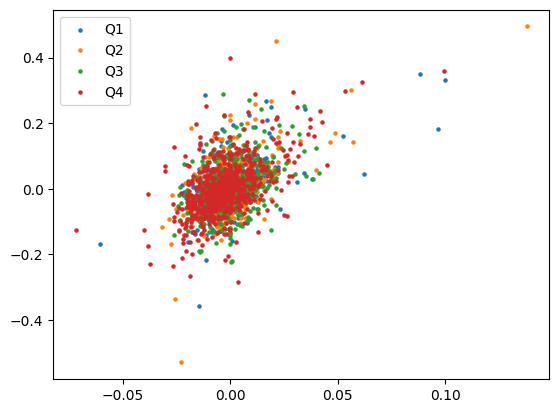

In [27]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

d = day_data.dropna()
volume_quantiles = d['VolumeEodRatioPre'].quantile([0.0, 0.25, 0.50, 0.75, 1.0]).to_numpy()

for i, (bottom, top) in enumerate(zip(volume_quantiles, volume_quantiles[1:])):
    dq = d[(d['VolumeEodRatioPre'] >= bottom) & (d['VolumeEodRatioPre'] < top)]
    plt.scatter(
        dq['Gap'],
        dq['ChangeRatioMeanMorning'],
        s=5,
        label=f"Q{i+1}",
    )

plt.legend()
plt.show()

In [30]:
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split
import numpy as np

def train_model(x: pd.DataFrame, y: pd.DataFrame, classifier: bool):
    model = (MLPClassifier if classifier else MLPRegressor)(
        hidden_layer_sizes=(
            len(features) * 4,
            len(features) * 4,
            len(features) * 4,
            len(features),
        ),
        solver='adam',
        activation='relu',
        alpha=1e-9,
        learning_rate='adaptive',
        learning_rate_init=1e-3,
        max_iter=int(1e100),
    )
    X_train, X_test, y_train, y_test = train_test_split(x, y)
    model.fit(X_train, y_train)
    return model, X_train, X_test, y_train, y_test, x, y

initial test set score: -0.006367321522937175
cross_val_score: [-0.04044558  0.01996921 -0.05081262 -0.04666821 -0.03570203]


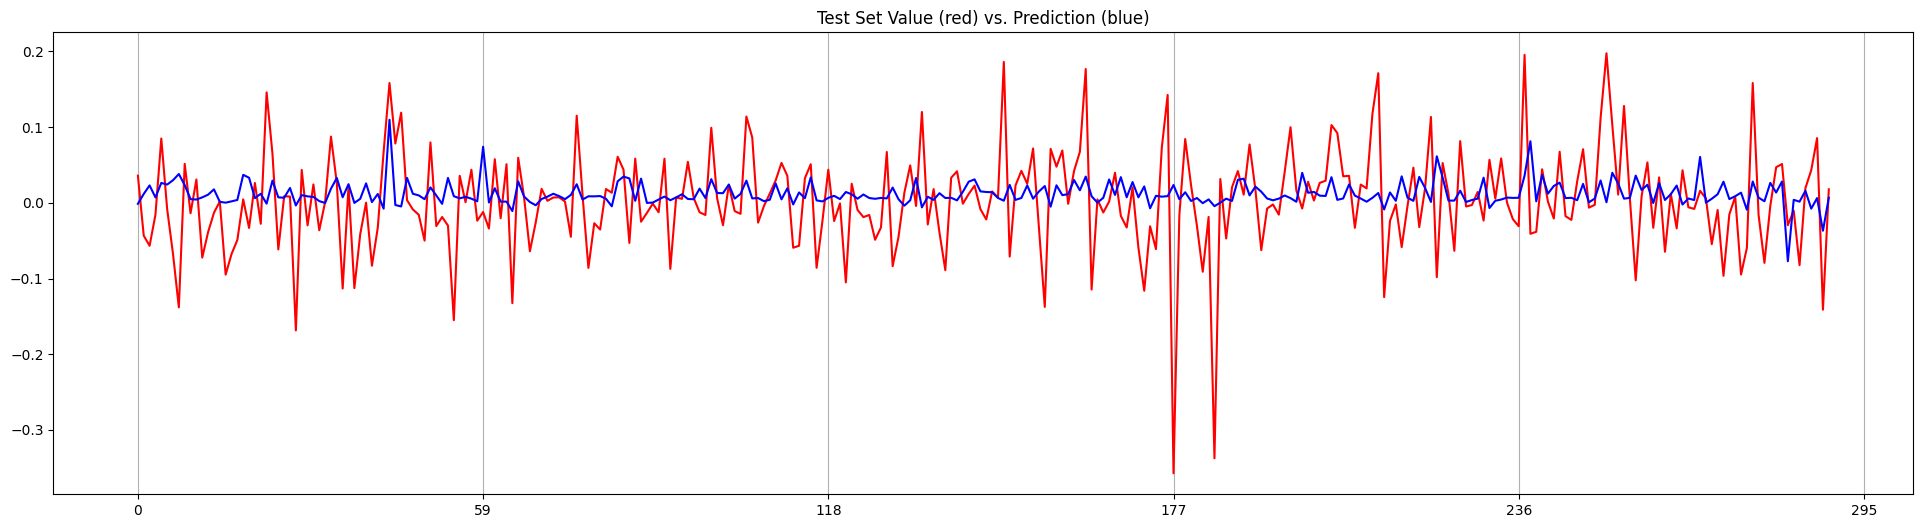

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score

model_data = day_data[(day_data['UpAndDownStatus'] == 0)].dropna()

model, X_train, X_test, y_train, y_test, x, y = train_model(
    model_data[['ChangeRatioStdPre', 'ChangeRatioMeanPre', 'Gap', 'ChangeRatioEodPre']],
    model_data['ChangeRatioMeanMorning'],
    classifier=False
)

predictions = model.predict(X_test)
plt.figure(figsize=(24, 6))
plt.title('Test Set Value (red) vs. Prediction (blue)')
plt.xticks(np.arange(0, 300, 59))
plt.grid(axis='x')
plt.plot(y_test.to_numpy()[0:290], color='red')
plt.plot(predictions[0:290], color='blue')

print('initial test set score:', model.score(X_test, y_test))
print('cross_val_score:', cross_val_score(model, x, y))

initial test set score: 0.40648296480150425
cross_val_score: [0.4673735  0.34171203 0.43009767 0.35201491 0.3125529 ]


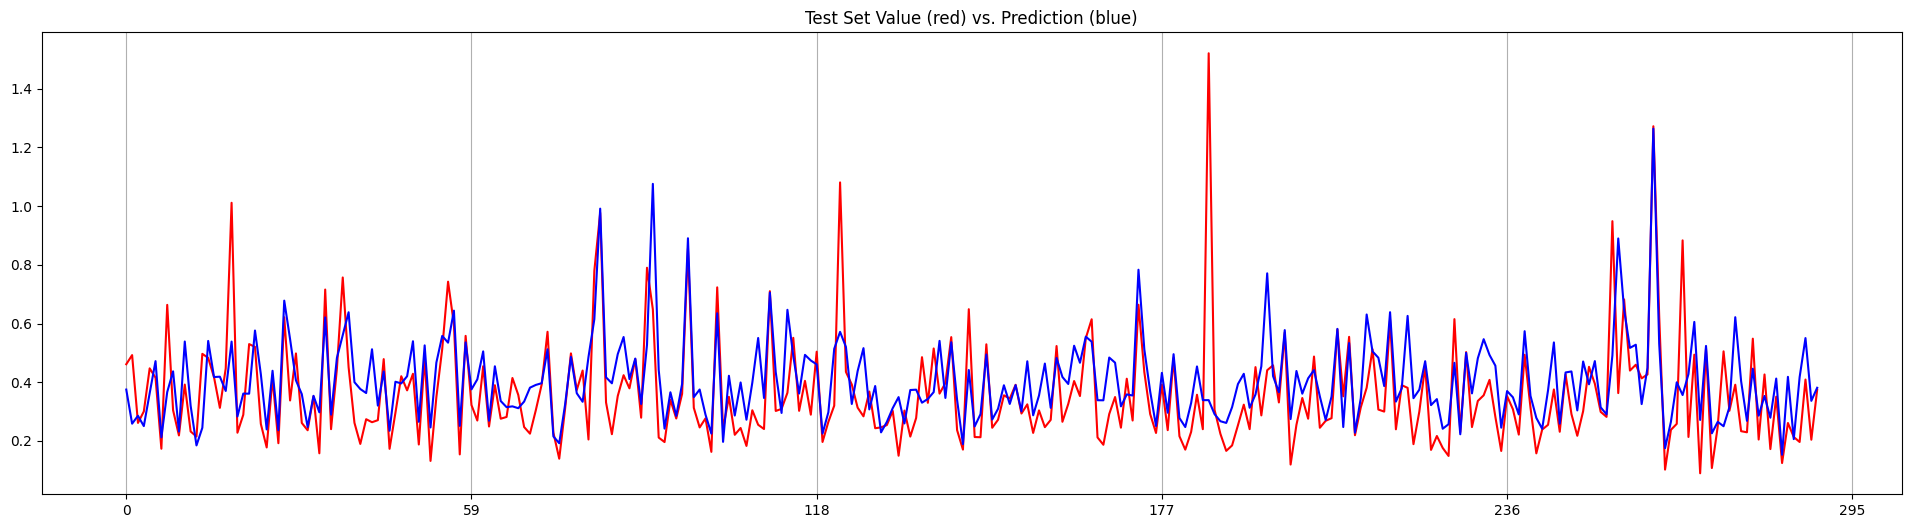

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score

model_data = day_data[(day_data['UpAndDownStatus'] == 0)].dropna()

model, X_train, X_test, y_train, y_test, x, y = train_model(
    model_data[['ChangeRatioStdPre', 'ChangeRatioMeanPre', 'Gap', 'ChangeRatioEodPre']],
    model_data['ChangeRatioStdMorning'],
    classifier=False
)

predictions = model.predict(X_test)
plt.figure(figsize=(24, 6))
plt.title('Test Set Value (red) vs. Prediction (blue)')
plt.xticks(np.arange(0, 300, 59))
plt.grid(axis='x')
plt.plot(y_test.to_numpy()[0:290], color='red')
plt.plot(predictions[0:290], color='blue')

print('initial test set score:', model.score(X_test, y_test))
print('cross_val_score:', cross_val_score(model, x, y))

## Conclusion

Using MLP regressor and classifier to predict next morning (9:30 to 10:00) change ratio std has some accuracy. (Predicting the mean has bad accuracy)



Suggested next step: try using a different scoring function, try manually constructing a factor (from the existing features), try isolating a time period where the model is accurate (may have insufficient data for validation).